In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import subprocess
import itertools

%matplotlib inline

In [28]:
f = subprocess.check_output(["ls"]).split()
files = []
#make list of files that contain ellipse data
for i in f:
    if "ellipseList.txt" in i:
        files.append(i)
print files

['FDDB-fold-01-ellipseList.txt', 'FDDB-fold-02-ellipseList.txt', 'FDDB-fold-03-ellipseList.txt', 'FDDB-fold-04-ellipseList.txt', 'FDDB-fold-05-ellipseList.txt', 'FDDB-fold-06-ellipseList.txt', 'FDDB-fold-07-ellipseList.txt', 'FDDB-fold-08-ellipseList.txt', 'FDDB-fold-09-ellipseList.txt', 'FDDB-fold-10-ellipseList.txt']


In [29]:
imginfo = {}

In [30]:
#container for ellipse data
class ellipse:
    def __init__(self,s):
        ellipse_info = s.split(" ")
        axes = [float(ellipse_info[0]),float(ellipse_info[1])]
        self.major_axis = max(axes)
        self.minor_axis = min(axes)
        #print axes
        assert self.major_axis >= self.minor_axis
        self.angle = float(ellipse_info[2])
        self.cx = float(ellipse_info[3])
        self.cy = float(ellipse_info[4])
        focus = np.sqrt(np.square(self.major_axis)-np.square(self.minor_axis))
        #print focus
        #print self.cx-np.cos(self.angle)*focus
        #print self.cy-np.sin(self.angle)*focus
        #print
        self.foci = np.array([(self.cx-np.cos(self.angle)*focus,self.cy-np.sin(self.angle)*focus),(self.cx+np.cos(self.angle)*focus,self.cy+np.sin(self.angle)*focus)])
        self.foci_dist = np.sqrt(np.square(focus)+np.square(self.minor_axis))
        self.area = np.pi*self.minor_axis*self.major_axis
    def pixel_score(self, xy):
        if (np.linalg.norm([xy[0]-self.foci[0][0],xy[1]-self.foci[0][1]]) + np.linalg.norm([xy[0]-self.foci[1][0],xy[1]-self.foci[1][1]])) <= 2*self.foci_dist:
            #print "For pixel "
            #print xy
            #print "Foci are "
            #print self.foci
            return 1
        return 0
    def score(self, winx, winy, half_width = 16):
        intersect = sum(map(self.pixel_score,itertools.product(xrange(winx-half_width,winx+half_width+1),xrange(winy-half_width,winy+half_width+1))))
        union = np.square(half_width*2+1) + self.area - intersect
        #print intersect/union
        return intersect/union

In [31]:
#read and populate array iminfo with the information about ellipses of images
#images can have variable numbers of ellipses
def info(filename):
    with open(filename,"r") as f:
        while(True):
            try:
                imgpath = f.readline().split("\n")[0]+".jpg"
                imginfo[imgpath] = []
                numfaces = f.readline().strip()
                #print numfaces
                for i in xrange(int(numfaces)):
                    imginfo[imgpath].append(ellipse(f.readline().split("\n")[0]))
            except ValueError as e:
                #pass
                return
    return

In [32]:
#store ellipse data for all images
map(info,files)

[None, None, None, None, None, None, None, None, None, None]

In [33]:
len(imginfo)

2846

In [34]:
def create_windows(imfile,e):
    #for ellip in ellipses:
    image = cv2.imread(imfile,0)
    positions = [-6,-4,-2,0,2,4,6] #centering of windows
    window_center = list(itertools.product(positions,positions))
    
    #get subsection of image centered at data[1]. data[0] is the ellipse instance for the image
    window_gen = lambda data: image[int(data[0].cy+data[1][1]) - 16:int(data[0].cy+data[1][1]) + 17,int(data[0].cx+data[1][0]) - 16:int(data[0].cx+data[1][0]) + 17]
    
    #get scoring information for each window
    scoring = lambda data: data[0].score(int(data[0].cx+data[1][0]),int(data[0].cy+data[1][1])) #implement the scoring function
    
    report = lambda data: [window_gen(data),scoring(data)]
    
    #get images for all windows for all image files
    scored_data = map(report,itertools.product(e,window_center))
    
    #DEBUG: check if images have >1 ellipses
    #if len(e)>1:
    #    print len(windows)
    #print "Done with image file %s"%imfile
    return scored_data

In [51]:
#get image squares for all images
image_windows = lambda i: create_windows(imginfo.keys()[i],imginfo[imginfo.keys()[i]])
#all_image_windows = map(image_windows,xrange(len(imginfo)))
all_image_windows = map(image_windows,(np.random.rand(50)*2000).astype(int))

In [62]:
#how many total images
#plt.imshow(all_image_windows[1][0][0],cmap="gray",interpolation="nearest")

(50,)


In [53]:
def show(i):
    print all_image_windows[i][0][1]
    plt.imshow(all_image_windows[i][0][0],cmap="gray",interpolation="nearest")
    plt.show()
def show_max():
    
    max_score = np.argmax(all_image_windows[])
    print all_image_windows[max_score,0,1]
    plt.imshow(all_image_windows[max_score][0][0],cmap="gray",interpolation="nearest")
    plt.show()

0.137444191959


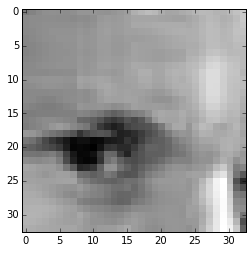

In [69]:
show(49)

In [72]:
all_image_windows[0][0][0] < 50

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)